#  Prediction on MAVEs

## Libraries, functions and dictionaries

In [46]:
import sys, os

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import random
import seaborn as sns

from scipy.optimize import curve_fit
from scipy import stats

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from catboost.datasets import titanic

import warnings
warnings.filterwarnings('ignore')

In [47]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

alphabetAA_to_classes={'A':1,'C':2,'D':3,'E':3,'F':1,'G':4,'H':3,'I':1,'K':3,'L':1,'M':1,'N':2,'P':4,'Q':2,'R':3,'S':2,'T':2,'V':1,'W':1,'Y':1}
alphabetclasses_to_AA={v: k for k,v in alphabetAA_to_classes.items()}

AA_ddsp_number={'H' :0,'B' : 1,'E' : 2,'G' : 3,'I' : 4,'T' : 5,'S' : 6,' ' : 7}
AA_number_ddsp={v: k for k,v in AA_ddsp_number.items()}

AA_ddsp_number_simp={'H' :0,'E' : 1,'C' : 2}
AA_number_ddsp_simp={v: k for k,v in AA_ddsp_number.items()}

AA_to_hydrophobicity_scores={'A':44,'C':50,'D':-37,'E':-12,'F':96,'G':0,'H':-16,'I':100,'K':-30,'L':99,'M':74,'N':-35,'P':-46,'Q':-14,'R':-20,'S':-6,'T':13,'V':78,'W':90,'Y':57}

### Load functions

In [48]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [134]:
def load_data_V2(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if not mutation_load[i][len(mutation_load[i])-1] in ['=','*','~']:
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

### General functions

In [50]:
def normalize_score(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.percentile(scores[~np.isnan(scores)],5)
    c_max_act=np.percentile(scores[~np.isnan(scores)],95)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [51]:
def normalize_minmax(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.amin(scores[~np.isnan(scores)])
    c_max_act=np.amax(scores[~np.isnan(scores)])
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [52]:
def normalize_fermi(scores):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=1/(sp.exp(scores[i,j]-2)+1)                 
    return normalized_scores

In [53]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [54]:
def position_mean(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        count=0
        flag_nan=True
        for j in range(score.shape[1]):
            if np.isnan(score[i,j])==False:
                flag_nan=False
                score_mean[i]+=score[i,j]
                count+=1
            else:
                pass
        if flag_nan==True:
            score_mean[i]=np.nan
        score_mean[i]/=count
        
    return score_mean

In [55]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):

    counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_unstable=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_unstable+=counts[i]
    print('Wt-like variants:',np.sum(counts)-sum_unstable, ' (', (np.sum(counts)-sum_unstable)/np.sum(counts) ,')')
    
    #plt.show()

In [56]:
def heatmap_IBS(prediction,variant_map,WT):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    
    ax.imshow(np.transpose(scores), aspect = 'auto', cmap=mpl.colors.ListedColormap(["white","#56b4e9"]))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels,fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)
        
    tmp=np.empty((len(WT),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT)):
        tmp[i,alphabetAA_L_D[WT[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')
    
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation",fontsize=16)
    plt.xlabel("residue",fontsize=16)

    plt.ylim(-0.5,19.5)

In [57]:
def ratio_variants(mave_funct,mave_abd):
    ratio=np.copy(mave_funct)
    ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(mave_funct[i,j]) or np.isnan(mave_abd[i,j]):
                pass
            else:
                if mave_abd[i,j]==0.0:
                    ratio[i,j]=mave_funct[i,j]/0.0000001
                else:
                    ratio[i,j]=mave_funct[i,j]/mave_abd[i,j]
    sig_ratio=np.copy(ratio)
    sig_ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(ratio[i,j])!=True:
                sig_ratio[i,j]=1/(1+np.exp(-(ratio[i,j]-1)))

    return sig_ratio

In [58]:
def MCC_test_subset(prediction,test):
    TP=0
    FP=0
    total=0
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if int(test[i])==1:
                total+=1
    precision=TP/(TP+FP)
    recall=TP/total
    mcc=np.sqrt(abs(precision*recall))
    
    return precision,recall,mcc                 

In [59]:
def AUC_subset(prediction,test):
    TP=0
    FP=0
    FN=0
    TN=0
    
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if prediction[i]==0:
                if int(prediction[i])==int(test[i]):
                    TN+=1
                else:
                    FN+=1 
                    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    
    return [TPR,FPR]

In [60]:
def retrieve_residue_label_pred(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage_mode=np.zeros((len(WT),2),dtype=float)
    
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            count_1=0
            for j in range(scores.shape[1]):
                if scores[i,j]==1:
                    count_1+=1
            percentage=count_1/count
            
            if percentage > percentage_threshold:
                pseudomode_value_class[i]=1
            else:
                pseudomode_value_class[i]=0
            
            percentage_mode[i,0]=percentage
            percentage_mode[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage_mode

In [61]:
def pairplot_features(list_feature,name_features,namefile):
    df=pd.DataFrame(list_feature,columns=name_features)
    sns_plot=sns.pairplot(df)
    sns_plot.savefig(namefile)

In [62]:
def print_chimera_attribute_file(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            file.write("\t%s%d%s\t%f\n" % (':',i+1,'.A',-1))
        else:
            file.write("\t%s%d%s\t%f\n" % (':',i+1,'.A',attribute[i]))
    file.close()

In [63]:
def plot_attributes(pos,pred,variant_map,gemme,rosetta,wcn,gemme_n,rosetta_n):
    
    label_position=np.empty(20,dtype=float)
    label_position[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            label_position[cord[1]]=prediction[i]
        i+=1
    
    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(9,4),gridspec_kw={"width_ratios" : [7,1,1,1,1,1], "wspace" : 0.4})
    cdict = {1: 'blue', 0: 'red'}
    glabel={1.0:'SBI',0.0:'non-SBI'}
    for g in np.unique(label_position):
        if np.isnan(g)!=True:
            ix = np.where(label_position == g)
            ax1.scatter(rosetta[pos,ix],gemme[pos,ix],c=cdict[g], label=[glabel[g]])
    
    ax2.bar(x=0.5,height=wcn[pos])
    ax3.bar(x=0.5,height=np.mean(gemme[pos,:][~np.isnan(gemme[pos,:])]))
    ax4.bar(x=0.5,height=np.mean(rosetta[pos,:][~np.isnan(rosetta[pos,:])]))   
    ax5.bar(x=0.5,height=gemme_n[pos])
    ax6.bar(x=0.5,height=rosetta_n[pos])
    
    
    ax1.set_title('variants classification')
    ax2.set_title('WCN')
    ax3.set_title(r'$\bar{G}$')
    ax4.set_title(r'$\bar{r}$')
    ax5.set_title(r'G_n')
    ax6.set_title(r'r_n')
    
    ax1.set_xlabel('rosetta_score',fontsize=13)
    ax1.set_ylabel('GEMME score',fontsize=13)
    ax1.set_xlim(6,-1)
    ax1.set_ylim(-7,1)
    ax2.set_ylim(0,15)
    ax3.set_ylim(0,-8)
    ax4.set_ylim(0,6)
    ax5.set_ylim(0,-8)
    ax6.set_ylim(0,6)
    
    
    ax2.set_xticks([],[])
    ax3.set_xticks([],[])
    ax4.set_xticks([],[])
    ax5.set_xticks([],[])
    ax6.set_xticks([],[])
    ax2.set_xlim(0.1,0.9)
    
    
    
    ax1.legend()

In [64]:
def results_plot(MCC,AUC,name_models):
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,4))
    
    cdict = {1: '#355070', 2: '#6D597A',2:'#B56576',3 :'#a4d600',4:'#a47f4b',5:'#EAAC8B',6:'#4a944f',7:"#F95738"}
    for g in range(0,7):
        ax1.scatter(AUC[g,1],AUC[g,0],c=cdict[g+1])
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes,ls=':')
    ax1.set_xlabel('FPR',fontsize=13)
    ax1.set_ylabel('TPR',fontsize=13)
    
    for g in range(0,7):
        ax2.scatter(MCC[g,0],MCC[g,1],c=cdict[g+1], label=g+1)
    #ax2.scatter(MCC[:,0],MCC[:,1],c=color_class)
    
    ax2.set_xlabel('Precision',fontsize=13)
    ax2.set_ylabel('Recall',fontsize=13)
    ax2.legend(loc='lower right')
    
    cbar=[cdict[i] for i in range(1,8)]
    ax3.bar(name_models,MCC[:,2],color=cbar)
    ax3.set_ylabel('MCC',fontsize=13)


In [65]:
def print_percentage_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    print(f' SBI variants: {count_SBI} out of {len(pred)} ({count_SBI/len(pred)*100:.2f}%) ')
    
    perc_variants=count_SBI/len(pred)*100
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    print(f' SBI residues: {count_SBI} out of {effective_pos} ({count_SBI/effective_pos*100:.2f}%) ')
    
    return [perc_variants, count_SBI/effective_pos*100]

In [66]:
def print_numbers_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    variants=count_SBI
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    
    return [variants, count_SBI]

In [67]:
def classification_histogram_shadowed2(score_back,score_filter,nbin,b_min,b_max,color,label_x,region_ext):
    # Function for plot the MAVE coloured variants distribution using the computational scores
    
    mpl.rcParams['figure.figsize']=(6,3)    
    mpl.rcParams['axes.axisbelow'] = True
    mpl.rcParams['xtick.labelsize'] = 14
    mpl.rcParams['ytick.labelsize'] = 14
    mpl.rcParams['axes.labelsize']  = 15
    
    temp=np.copy(score_back)
    
    for i in range(score_back.shape[0]):
        for j in range(score_back.shape[1]):
            if np.isnan(score_filter[i,j]):
                temp[i,j]=np.nan

    #histogram data of the gray distribution on background
    counts, bins = np.histogram(temp[~np.isnan(temp)],bins=nbin)
    
    c_bins=np.copy(bins)
    c_counts=np.copy(counts)
    i=0
    temp_cmin=0

    # Fix the bins over the the limit plot region(b_min/b_max), to make them collapse into a single bin 
    while i < len(c_bins):

        if c_bins[i] > b_min:
            c_bins=np.delete(c_bins,np.s_[0:i-1])
            c_counts=np.delete(c_counts,np.s_[0:i-1])
            break

        temp_cmin+=counts[i]
        i+=1
  
    i=len(c_bins)-1
    temp_cmax=0
    
    while i >=0:

        if c_bins[i] <= b_max:
            c_bins=np.delete(c_bins,np.s_[i+2:])
            c_counts=np.delete(c_counts,np.s_[i+1:])
            break
            
        temp_cmax+=c_counts[i-1]
        i-=1 
        
    c_counts[0]=temp_cmin
    c_counts[-1]=temp_cmax 
    fig,ax=plt.subplots(1,1,figsize=(5,4),tight_layout=True)    
    #max-min normalization for background scores
    norm= (c_counts-np.min(c_counts))/(np.max(c_counts)-np.min(c_counts))

    #plot background gray histogram
    ax.hist(c_bins[:-1], c_bins, weights=norm, facecolor='gray', alpha=0.4,edgecolor="k",histtype='stepfilled')
    
    
    temp=[]
    for i in range(score_back.shape[0]):
        for j in range(score_back.shape[1]):
            if score_filter[i,j]==region_ext[0]:
                temp.append(score_back[i,j])

    temp=np.array(temp)

    # Plot of coloured variants of MAVE using the score distribution of the computational analysis
    counts_filter, bins2 = np.histogram(temp[~np.isnan(temp)],bins=bins)

    # Fix the bins over the the limit plot region(b_min/b_max), to make them collapse into a single bin 
    # Extraction of the MAVE variants distribution of the region from the computational score .
    cf_bins=np.copy(bins2)
    cf_counts=np.copy(counts_filter)
    i=0
    temp_cmin=0
    while i < len(cf_bins):

        if cf_bins[i] > b_min:
            cf_bins=np.delete(cf_bins,np.s_[0:i-1])
            cf_counts=np.delete(cf_counts,np.s_[0:i-1])
            break

        temp_cmin+=cf_counts[i]
        i+=1
  
    i=len(cf_bins)-1
    temp_cmax=0
    
    while i >=0:

        if cf_bins[i] <= b_max:
            cf_bins=np.delete(cf_bins,np.s_[i+2:])
            cf_counts=np.delete(cf_counts,np.s_[i+1:])
            break
            
        temp_cmax+=cf_counts[i-1]
        i-=1 

    cf_counts[0]=temp_cmin
    cf_counts[-1]=temp_cmax 
    
    # Max-min normalization for the front couloured distribution
    norm_filter=np.copy(norm)
    for i in range(len(norm_filter)):
        if c_counts[i] != 0:
            norm_filter[i]= cf_counts[i]*norm[i]/c_counts[i]

            

    temp=[]
    for i in range(score_back.shape[0]):
        for j in range(score_back.shape[1]):
            if score_filter[i,j]==region_ext[1]:
                temp.append(score_back[i,j])

    temp=np.array(temp)

    # Plot of coloured variants of MAVE using the score distribution of the computational analysis
    counts_filter, bins2 = np.histogram(temp[~np.isnan(temp)],bins=bins)

    # Fix the bins over the the limit plot region(b_min/b_max), to make them collapse into a single bin 
    # Extraction of the MAVE variants distribution of the region from the computational score .
    cf_bins=np.copy(bins2)
    cf_counts=np.copy(counts_filter)
    i=0
    temp_cmin=0
    while i < len(cf_bins):

        if cf_bins[i] > b_min:
            cf_bins=np.delete(cf_bins,np.s_[0:i-1])
            cf_counts=np.delete(cf_counts,np.s_[0:i-1])
            break

        temp_cmin+=cf_counts[i]
        i+=1
  
    i=len(cf_bins)-1
    temp_cmax=0
    
    while i >=0:

        if cf_bins[i] <= b_max:
            cf_bins=np.delete(cf_bins,np.s_[i+2:])
            cf_counts=np.delete(cf_counts,np.s_[i+1:])
            break
            
        temp_cmax+=cf_counts[i-1]
        i-=1 

    cf_counts[0]=temp_cmin
    cf_counts[-1]=temp_cmax 
    
    # Max-min normalization for the front couloured distribution
    norm_filter2=np.copy(norm)
    for i in range(len(norm_filter)):
        if c_counts[i] != 0:
            norm_filter2[i]= cf_counts[i]*norm[i]/c_counts[i]            
            
            
            
    # plot of front coloured distribution
    ax.hist([c_bins[:-1],c_bins[:-1]],  c_bins, weights=[norm_filter,norm_filter2], color=color,stacked=True, edgecolor="black",histtype='stepfilled')

    ax.set_xlabel(label_x)
    ax.set_ylabel('Normalized counts')
    plt.grid(axis="y",alpha=0.4,linestyle='--')

In [68]:
def classification_histogram_shadowed(score_back,score_filter,nbin,b_min,b_max,color,label_x,region_ext):
    # Function for plot the MAVE coloured variants distribution using the computational scores
    
    mpl.rcParams['figure.figsize']=(6,3)    
    mpl.rcParams['axes.axisbelow'] = True
    mpl.rcParams['xtick.labelsize'] = 14
    mpl.rcParams['ytick.labelsize'] = 14
    mpl.rcParams['axes.labelsize']  = 15
    
    temp=np.copy(score_back)
    
    for i in range(score_back.shape[0]):
        for j in range(score_back.shape[1]):
            if np.isnan(score_filter[i,j]):
                temp[i,j]=np.nan

    #histogram data of the gray distribution on background
    counts, bins = np.histogram(temp[~np.isnan(temp)],bins=nbin)
    
    c_bins=np.copy(bins)
    c_counts=np.copy(counts)
    i=0
    temp_cmin=0

    # Fix the bins over the the limit plot region(b_min/b_max), to make them collapse into a single bin 
    while i < len(c_bins):

        if c_bins[i] > b_min:
            c_bins=np.delete(c_bins,np.s_[0:i-1])
            c_counts=np.delete(c_counts,np.s_[0:i-1])
            break

        temp_cmin+=counts[i]
        i+=1
  
    i=len(c_bins)-1
    temp_cmax=0
    
    while i >=0:

        if c_bins[i] <= b_max:
            c_bins=np.delete(c_bins,np.s_[i+2:])
            c_counts=np.delete(c_counts,np.s_[i+1:])
            break
            
        temp_cmax+=c_counts[i-1]
        i-=1 
        
    c_counts[0]=temp_cmin
    c_counts[-1]=temp_cmax 
    fig,ax=plt.subplots(1,1,figsize=(5,4),tight_layout=True)    
    #max-min normalization for background scores
    norm= (c_counts-np.min(c_counts))/(np.max(c_counts)-np.min(c_counts))

    #plot background gray histogram
    ax.hist(c_bins[:-1], c_bins, weights=norm, facecolor='gray', alpha=0.4,edgecolor="k",histtype='stepfilled')
    
    temp=[]
    for i in range(score_back.shape[0]):
        for j in range(score_back.shape[1]):
            if score_filter[i,j]==region_ext:
                temp.append(score_back[i,j])

    temp=np.array(temp)

    # Plot of coloured variants of MAVE using the score distribution of the computational analysis
    counts_filter, bins2 = np.histogram(temp[~np.isnan(temp)],bins=bins)

    # Fix the bins over the the limit plot region(b_min/b_max), to make them collapse into a single bin 
    # Extraction of the MAVE variants distribution of the region from the computational score .
    cf_bins=np.copy(bins2)
    cf_counts=np.copy(counts_filter)
    i=0
    temp_cmin=0
    while i < len(cf_bins):

        if cf_bins[i] > b_min:
            cf_bins=np.delete(cf_bins,np.s_[0:i-1])
            cf_counts=np.delete(cf_counts,np.s_[0:i-1])
            break

        temp_cmin+=cf_counts[i]
        i+=1
  
    i=len(cf_bins)-1
    temp_cmax=0
    
    while i >=0:

        if cf_bins[i] <= b_max:
            cf_bins=np.delete(cf_bins,np.s_[i+2:])
            cf_counts=np.delete(cf_counts,np.s_[i+1:])
            break
            
        temp_cmax+=cf_counts[i-1]
        i-=1 

    cf_counts[0]=temp_cmin
    cf_counts[-1]=temp_cmax 
    
    # Max-min normalization for the front couloured distribution
    norm_filter=np.copy(norm)
    for i in range(len(norm_filter)):
        if c_counts[i] != 0:
            norm_filter[i]= cf_counts[i]*norm[i]/c_counts[i]
            
    # plot of front coloured distribution
    ax.hist(c_bins[:-1], c_bins, weights=norm_filter, facecolor=color,stacked=True, edgecolor="black",histtype='stepfilled')

    ax.set_xlabel(label_x)
    ax.set_ylabel('Normalized counts')
    plt.grid(axis="y",alpha=0.4,linestyle='--')

### setup ML functions

In [69]:
def blosum62_score(WT,scores):
    blosum_prot=np.empty((len(WT),20),dtype=float)
    
    for i in range(len(WT)):
        for j in range(20):
            blosum_prot[i,j]=scores[alphabetAA_L_D[WT[i]]-1,j]
            
    return blosum_prot

In [70]:
def secondary_structure_cat(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=False)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    
    count=1
    for j in range(len(WT)):
        if WT[j]!='-':
            for i in range(len(ss_labels[0,:])):
                if count==int(str(chainA_top.residue(i))[3:]):
                    ss_ret_labels[j]=AA_ddsp_number[ss_labels[0,i]]
    
    return ss_ret_labels
    

In [71]:
def secondary_structure_cat_simp(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=True)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    count=1
    for j in range(len(WT)):
        if WT[j]!='-':
            for i in range(len(ss_labels[0,:])):
                if count==int(str(chainA_top.residue(i))[3:]):
                    ss_ret_labels[j]=AA_ddsp_number_simp[ss_labels[0,i]]
            count+=1
    return ss_ret_labels
    

In [72]:
def WCN(pdb_loc,scheme_e,WT):
    r0=7.0
    pdb=md.load(pdb_loc)
    topology=pdb.topology
    chainA=topology.select('chainid 0 and protein')
    pdb_chain0=pdb.atom_slice(chainA)
    pdb_dist,pdb_rp=md.compute_contacts(pdb_chain0,scheme=scheme_e,periodic=False)
    
    cm= md.geometry.squareform(pdb_dist,pdb_rp)[0]
    wcn=np.zeros((len(WT)),dtype=float)
    
    cm_adj=np.empty((len(WT),len(WT)),dtype=float)
    cm_adj[:]=np.nan
    chainA_top=pdb_chain0.topology
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cm_adj[int(str(chainA_top.residue(i))[3:])-1,int(str(chainA_top.residue(j))[3:])-1]=cm[i,j]
    for i in range(len(WT)):
        nan_flag=True
        for j in range(len(WT)):
            if np.isnan(cm_adj[i,j])!=True and cm_adj[i,j]!=0.0:
                nan_flag=False
                wcn[i]+=(1-(cm_adj[i,j]*10/r0)**6)/(1-(cm_adj[i,j]*10/r0)**12)
        if nan_flag==True:
            wcn[i]=np.nan
            
    wcn_reorder=np.empty((len(WT)),dtype=float)
    wcn_reorder[:]=np.nan
    count=0
    for i in range(len(wcn_reorder)):
        if WT[i]!='-':
            wcn_reorder[i]=wcn[count]
            count+=1
    return wcn_reorder

In [73]:
def neighbor_scores(score,ext_range):
    score_neighborhood=np.zeros(len(score),dtype=float)
    for i in range(len(score)):
        if np.isnan(score[i])!=True:
            count_nan=0
            if i==0:
                for j in range(1,ext_range+1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range:    
                    score_neighborhood[i]/=(ext_range)
                else:
                    score_neighborhood[i]=np.nan

            elif i==(len(score)-1):
                for j in range(len(score)-1-ext_range,len(score)-1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range: 
                    score_neighborhood[i]/=ext_range
                else:
                    score_neighborhood[i]=np.nan                
            elif i<ext_range:
                for j in range(0,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(i+ext_range):    
                    score_neighborhood[i]/=(i+ext_range)
                else:
                    score_neighborhood[i]=np.nan                        

            elif i>(len(score)-1-ext_range):
                for j in range(i-ext_range,len(score)):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(len(score)-i+ext_range):                     
                    score_neighborhood[i]/=(len(score)-i+ext_range)
                else:
                    score_neighborhood[i]=np.nan  
            else:
                for j in range(i-ext_range,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(2*ext_range):  
                    score_neighborhood[i]/=(2*ext_range)
                else:
                    score_neighborhood[i]=np.nan             
        else:
            score_neighborhood[i]=np.nan
    return score_neighborhood

In [74]:
def label_category(output,threshold):
    labels=[]
    if output.ndim==1:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(len(output)):
            if output[i]<threshold:
                labels[i]=0
            else:
                labels[i]=1
    else:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i,j]<threshold:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    return labels

In [75]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [76]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [77]:
def features_validation(list_features_x,WT):
    
    X=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
            

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    mapping_pos.append([i,j])
        
    return np.array(X),mapping_pos        

In [78]:
def binary_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    
    return labels

In [79]:
def multiclass_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                elif data_x[i,j] < t_x and data_y[i,j]<t_y:
                    labels[i,j]=2
                elif data_x[i,j] < t_x and data_y[i,j]>t_y:
                    labels[i,j]=3
                else:
                    labels[i,j]=0
    
    return labels

In [80]:
def prob_to_label(probability,thr):
    labels=np.zeros(probability.shape[0],dtype=int)
    for i in range(probability.shape[0]):
        if probability[i][1]>thr:
            labels[i]=1
            #print(1)
        else:
            labels[i]=0
            #print(0)
    return labels

In [81]:
def AS_CA_distance(CA_coord,AS_pos,target):
    AS_baricenter=np.zeros((3,1),dtype=float)
    
    for i in AS_pos:
        if np.isnan(CA_coord[i-1,:]).any():
            print(f'WARNING - no active site coordinates in pdb for position: {i}')
        else:
            AS_baricenter[0]+=CA_coord[i-1,0]
            AS_baricenter[1]+=CA_coord[i-1,1]
            AS_baricenter[2]+=CA_coord[i-1,2]
        
    AS_baricenter=AS_baricenter/len(AS_pos)

    dist=0
    
    if np.isnan(CA_coord[target-1,:]).any():   
        print(f'WARNING - no target coordinates in pdb for position: {i}')
    else:
        dist=sp.sqrt((AS_baricenter[0]-CA_coord[target-1,0])**2+(AS_baricenter[1]-CA_coord[target-1,1])**2+(AS_baricenter[2]-CA_coord[target-1,2])**2)
    
    return dist[0]

In [82]:
def gauss(x,mu,sigma,A):
    return A*sp.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)

def modal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [83]:
def distribution_experiments(prediction,variant_map,WT,mave):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
        
    mave_overlap=np.copy(mave)
    
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j]):
                mave_overlap[i,j]=np.nan
    return scores,mave_overlap

In [50]:
def print_accuracy_exp_predictions(mave_scores,pred_score,threshold,uo_tp, region_ext):
    temp=[]
    for i in range(mave_scores.shape[0]):
        for j in range(mave_scores.shape[1]):
            if pred_score[i,j]==region_ext:
                temp.append(mave_scores[i,j])
    temp=np.array(temp)
    TP=0
    FP=0

    for i,n in enumerate(temp):
        if not np.isnan(n):
            if uo_tp=='under':
                if n < threshold:
                    TP+=1
                else:
                    FP+=1
            if uo_tp=='over':
                if n>= threshold:
                    TP+=1
                else:
                    FP+=1
    if (FP+TP)==0:
        acc=np.nan
    else:
        acc=TP/(TP+FP)
    print(region_ext,TP,FP,acc)
    return [region_ext,TP,FP,acc]
            

## Load trained model

In [30]:
cat=CatBoostClassifier(iterations=2500, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1})

In [31]:
cat.load_model('../catboost_model/cat_trained_24jun22.cbm')

### P35520 - CBS

In [32]:
P35520_WT_sequence="MPSETPQAEVGPTGCPHRSGPHSAKGSLEKGSPEDKEAKEPLWIRPDAPSRCTWQLGRPASESPHHHTAPAKSPKILPDILKKIGDTPMVRINKIGKKFGLKCELLAKCEFFNAGGSVKDRISLRMIEDAERDGTLKPGDTIIEPTSGNTGIGLALAAAVRGYRCIIVMPEKMSSEKVDVLRALGAEIVRTPTNARFDSPESHVGVAWRLKNEIPNSHILDQYRNASNPLAHYDTTADEILQQCDGKLDMLVASVGTGGTITGIARKLKEKCPGCRIIGVDPEGSILAEPEELNQTEQTTYEVEGIGYDFIPTVLDRTVVDKWFKSNDEEAFTFARMLIAQEGLLCGGSAGSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGFLKEEDLTEKKPWWWHLRVQELGLSAPLTVLPTITCGHTIEILREKGFDQAPVVDEAGVILGMVTLGNMLSSLLAGKVQPSDQVGKVIYKQFKQIRLTDTLGRLSHILEMDHFALVVHEQIQYHSTGKSSQRQMVFGVVTAIDLLNFVAAQERDQK"
P35520_WT_seq_rose="------------------------------------------WIRPDAPSRCTWQLGRPASESPHHHTAPAKSPKILPDILKKIGDTPMVRINKIGKKFGLKCELLAKCEFFNAGGSVKDRISLRMIEDAERDGTLKPGDTIIEPTSGNTGIGLALAAAVRGYRCIIVMPEKMSSEKVDVLRALGAEIVRTPTNARFDSPESHVGVAWRLKNEIPNSHILDQYRNASNPLAHYDTTADEILQQCDGKLDMLVASVGTGGTITGIARKLKEKCPGCRIIGVDPEGSILAEPEELNQTEQTTYEVEGIGYDFIPTVLDRTVVDKWFKSNDEEAFTFARMLIAQEGLLCGGSAGSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGFLKEEDLTEKKPWWWHLRVQELGLSAPLTVLPTITCGHTIEILREKGFDQAPVVDEAGVILGMVTLGNMLSSLLAGKVQPSDQVGKVIYKQFKQIRLTDTLGRLSHILEMDHFALVVHEQ-------------MVFGVVTAIDLLNFVAAQER---"
P35520_WT_seq_mave="MPSETPQAEVGPTGCPHRSGPHSAKGSLEKGSPEDKEAKEPLWIRPDAPSRCTWQLGRPASESPHHHTAPAKSPKILPDILKKIGDTPMVRINKIGKKFGLKCELLAKCEFFNAGGSVKDRISLRMIEDAERDGTLKPGDTIIEPTSGNTGIGLALAAAVRGYRCIIVMPEKMSSEKVDVLRALGAEIVRTPTNARFDSPESHVGVAWRLKNEIPNSHILDQYRNASNPLAHYDTTADEILQQCDGKLDMLVASVGTGGTITGIARKLKEKCPGCRIIGVDPEGSILAEPEELNQTEQTTYEVEGIGYDFIPTVLDRTVVDKWFKSNDEEAFTFARMLIAQEGLLCGGSAGSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGFLKEEDLTEKKPWWWHLRVQELGLSAPLTVLPTITCGHTIEILREKGFDQAPVVDEAGVILGMVTLGNMLSSLLAGKVQPSDQVGKVIYKQFKQIRLTDTLGRLSHILEMDHFALVVHEQIQYHSTGKSSQRQMVFGVVTAIDLLNFVAAQERDQK"

In [33]:
count=0
for i in range(len(P35520_WT_sequence)):
    if P35520_WT_sequence[i]==P35520_WT_seq_rose[i]:
        count+=1
print(len(P35520_WT_sequence),count/len(P35520_WT_seq_rose))

551 0.8947368421052632


#### Co-evolution

In [35]:
P35520_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P35520.txt',P35520_WT_sequence)
P35520_GEMME=remove_WT_score(P35520_GEMME,P35520_WT_sequence)

In [36]:
P35520_GEMME_mean=position_mean(P35520_GEMME)

####  Rosetta ddG

In [37]:
P35520_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P35520.txt",P35520_WT_seq_rose,0)
P35520_rosetta_ddg=remove_WT_score(P35520_rosetta_ddg,P35520_WT_seq_rose)

In [38]:
P35520_rosetta_ddg_norm=normalize_cutoff(P35520_rosetta_ddg,0.0,5.0)

In [39]:
P35520_rosetta_ddg_mean=position_mean(P35520_rosetta_ddg_norm)

In [40]:
P35520_rosetta_ddg_mean_non=position_mean(P35520_rosetta_ddg)

#### Hydrophobicity

In [41]:
P35520_hydrophobicity_mut=np.empty((len(P35520_WT_sequence),20),dtype=float)
P35520_hydrophobicity_mut[:]=np.nan

In [42]:
for i in range(len(P35520_WT_sequence)):
    for j in range(20):
        P35520_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [44]:
P35520_wcn=WCN('../pdbs/P35520_4coo.pdb','ca',P35520_WT_sequence)

#### Neighbor sequences scores:

In [84]:
P35520_rosetta_neigbor_scores=neighbor_scores(P35520_rosetta_ddg_mean,1)

P35520_GEMME_neigbor_scores=neighbor_scores(P35520_GEMME_mean,1)

#### MAVE score

In [86]:
P35520_functional_mave=load_data_V2('../score_maves/prism_mave_006_CBS_high_B6_activity.txt',P35520_WT_seq_mave)

In [87]:
P35520_functional_mave[100,:]

array([0.2629, 0.2677, 0.021 , 0.1446, 0.6003, 0.0021, 0.1432, 0.6866,
       0.188 , 0.828 , 0.9791, 0.0834, 0.4233, 0.5084, 0.0314, 0.0125,
       0.2323, 0.541 , 0.1653, 0.3472])

Wt-like variants: 10960  ( 1.0 )


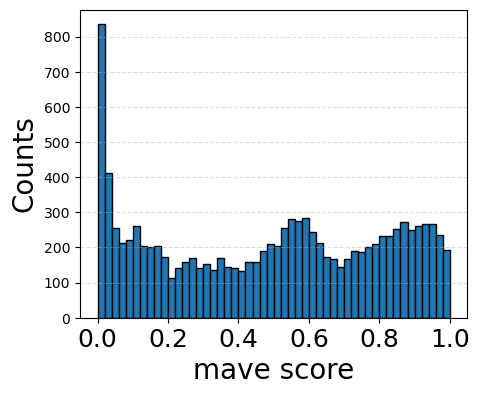

In [88]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
score_histogram(P35520_functional_mave,50,'C0','mave score',True,-7.5)
#plt.savefig('./Figures/P35520_CBS_MAVE_threshold_histogram.pdf')

### P62593 - BETA_ECOLX

In [89]:
BETA_WT_sequence="MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"
BETA_WT_seq_rose="-----------------------HPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRIDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"
BETA_WT_seq_mave="MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"

In [90]:
count=0
for i in range(len(BETA_WT_sequence)):
    if BETA_WT_sequence[i]==BETA_WT_seq_rose[i]:
        count+=1
print(len(BETA_WT_sequence),count/len(BETA_WT_seq_rose))

286 0.9125874125874126


#### BETA active site

In [91]:
BETA_db_positions=[68,71,128,164,232,235]

In [92]:
BETA_db_ligand_positions=[68,128,233,234,242]

#### Co-evolution

In [94]:
BETA_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P62593.txt',BETA_WT_sequence)
BETA_GEMME=remove_WT_score(BETA_GEMME,BETA_WT_sequence)

In [95]:
BETA_GEMME_mean=position_mean(BETA_GEMME)

####  Rosetta ddG

In [97]:
BETA_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P62593.txt",BETA_WT_seq_rose,0)
BETA_rosetta_ddg=remove_WT_score(BETA_rosetta_ddg,BETA_WT_seq_rose)

In [98]:
BETA_rosetta_ddg_norm=normalize_cutoff(BETA_rosetta_ddg,0.0,5.0)

In [99]:
BETA_rosetta_ddg_mean=position_mean(BETA_rosetta_ddg_norm)

#### Hydrophobicity

In [100]:
BETA_hydrophobicity_mut=np.empty((len(BETA_WT_sequence),20),dtype=float)
BETA_hydrophobicity_mut[:]=np.nan

In [103]:
for i in range(len(BETA_WT_sequence)):
    for j in range(20):
        BETA_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [104]:
BETA_wcn=WCN('../pdbs/P62593_1btl.pdb','ca',BETA_WT_sequence)

#### Neighbor sequences scores:

In [105]:
BETA_rosetta_neigbor_scores=neighbor_scores(BETA_rosetta_ddg_mean,1)

BETA_GEMME_neigbor_scores=neighbor_scores(BETA_GEMME_mean,1)

#### MAVE score

In [107]:
BETA_functional_mave=load_data_V2('../score_maves/prism_mave_999_bla_DMS_d.txt',BETA_WT_seq_mave)

In [108]:
y,x,_=plt.hist(BETA_functional_mave[~np.isnan(BETA_functional_mave)],50,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-6,0.2,600,-5,1,100,-1,2,300)
params,cov=curve_fit(bimodal,x,y,p0=expected)
sigma=sp.sqrt(sp.diag(cov))
plt.close()

In [109]:
gaus_fit_params=pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
print(gaus_fit_params)

             params         sigma
mu1       -6.012733  3.910306e+02
sigma1     0.053966  4.034390e+02
A1      1477.469385  2.916395e+07
mu2       -5.747106  5.002071e-01
sigma2     0.940753  2.895695e-01
A2       209.188951  4.102286e+01
mu3       -1.132100  1.010380e-01
sigma3     1.289492  1.100315e-01
A3       133.909786  8.666923e+00


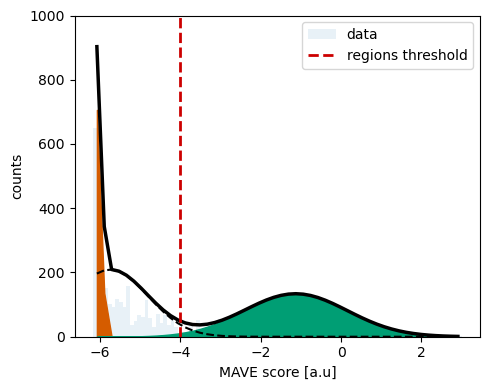

In [111]:
fig,ax=plt.subplots(1,1,figsize=(5,4),tight_layout=True)
ax.hist(BETA_functional_mave[~np.isnan(BETA_functional_mave)],100,alpha=.1,label='data')

ax.plot(x,gauss(x,gaus_fit_params.iloc[3,0],gaus_fit_params.iloc[4,0],gaus_fit_params.iloc[5,0]),color='black',zorder=3,ls='--')
ax.fill_between(x,gauss(x,gaus_fit_params.iloc[0,0],gaus_fit_params.iloc[1,0],gaus_fit_params.iloc[2,0]),color='#D55C00',zorder=2)
ax.fill_between(x,gauss(x,gaus_fit_params.iloc[6,0],gaus_fit_params.iloc[7,0],gaus_fit_params.iloc[8,0]),color='#009E74',zorder=2)
ax.plot(x,bimodal(x,*params),color='black',lw=2.5)
y_size=[0,1000]
vert_line = np.array( [-4 for i in range(len(y_size))])
ax.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=2)
ax.set_xlabel("MAVE score [a.u]")
ax.set_ylabel("counts")
ax.set_ylim(0,1000)
ax.legend()
#plt.savefig('./Figures/P62593_BETA_MAVE_threshold_histogram.pdf')

### P04386 - GAL4

In [112]:
P04386_WT_sequence="MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKRSPLTRAHLTEVESRLERLEQLFLLIFPREDLDMILKMDSLQDIKALLTGL"
P04386_WT_seq_rose="-------EQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKRSPLTRAHLTEVESRLERLEQLFLLIFPREDLDMILKMDSLQDIKALLTGL"
P04386_WT_seq_mave="-KLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKRSPLTRAHLTEVESRLERLE-------------------------------"

In [113]:
count=0
for i in range(len(P04386_WT_sequence)):
    if P04386_WT_sequence[i]==P04386_WT_seq_rose[i]:
        count+=1
print(len(P04386_WT_sequence),count/len(P04386_WT_seq_rose))

96 0.9270833333333334


#### Co-evolution

In [115]:
P04386_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P04386.txt',P04386_WT_sequence)
P04386_GEMME=remove_WT_score(P04386_GEMME,P04386_WT_sequence)

In [116]:
P04386_GEMME_mean=position_mean(P04386_GEMME)

####  Rosetta ddG

In [118]:
P04386_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P04386.txt",P04386_WT_seq_rose,0)
P04386_rosetta_ddg=remove_WT_score(P04386_rosetta_ddg,P04386_WT_seq_rose)

In [119]:
P04386_rosetta_ddg_norm=normalize_cutoff(P04386_rosetta_ddg,0.0,5.0)

In [120]:
P04386_rosetta_ddg_mean=position_mean(P04386_rosetta_ddg_norm)

In [121]:
P04386_rosetta_ddg_mean_non=position_mean(P04386_rosetta_ddg)

#### Hydrophobicity

In [122]:
P04386_hydrophobicity_mut=np.empty((len(P04386_WT_sequence),20),dtype=float)
P04386_hydrophobicity_mut[:]=np.nan

In [123]:
for i in range(len(P04386_WT_sequence)):
    for j in range(20):
        P04386_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [125]:
P04386_wcn=WCN('../pdbs/P04386_3coq.pdb','ca',P04386_WT_sequence)

#### Neighbor sequences scores:

In [126]:
P04386_rosetta_neigbor_scores=neighbor_scores(P04386_rosetta_ddg_mean,1)

P04386_GEMME_neigbor_scores=neighbor_scores(P04386_GEMME_mean,1)

#### MAVE score

In [135]:
P04386_functional_mave=load_data_V2('../score_maves/prism_mave_017_GAL4_histidinefree_growth_3_sel_a_40h.txt',P04386_WT_seq_mave)

In [136]:
y,x,_=plt.hist(P04386_functional_mave[~np.isnan(P04386_functional_mave)],100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-12,1,20,-5,2,30,0,1,50)
params,cov=curve_fit(bimodal,x,y,p0=expected)
sigma=sp.sqrt(sp.diag(cov))
plt.close()

In [137]:
gaus_fit_params=pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
print(gaus_fit_params)

           params     sigma
mu1    -11.813266  0.135634
sigma1   1.151446  0.141683
A1      13.693963  1.381671
mu2     -3.629838  0.305086
sigma2   2.329207  0.307624
A2      15.508334  1.000889
mu3     -0.066542  0.039705
sigma3   0.713193  0.054216
A3      38.528404  2.511162


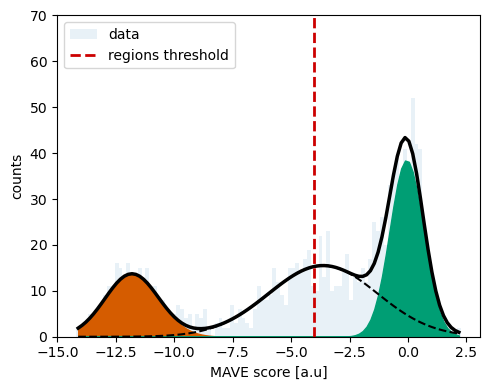

In [139]:
fig,ax=plt.subplots(1,1,figsize=(5,4),tight_layout=True)
ax.hist(P04386_functional_mave[~np.isnan(P04386_functional_mave)],100,alpha=.1,label='data')

ax.plot(x,gauss(x,gaus_fit_params.iloc[3,0],gaus_fit_params.iloc[4,0],gaus_fit_params.iloc[5,0]),color='black',zorder=3,ls='--')
ax.fill_between(x,gauss(x,gaus_fit_params.iloc[0,0],gaus_fit_params.iloc[1,0],gaus_fit_params.iloc[2,0]),color='#D55C00',zorder=2)
ax.fill_between(x,gauss(x,gaus_fit_params.iloc[6,0],gaus_fit_params.iloc[7,0],gaus_fit_params.iloc[8,0]),color='#009E74',zorder=2)
ax.plot(x,bimodal(x,*params),color='black',lw=2.5)

y_size=[0,70]
vert_line = np.array( [-4 for i in range(len(y_size))])
ax.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=2)
ax.set_xlabel("MAVE score [a.u]")
ax.set_ylabel("counts")
ax.set_ylim(0,70)
ax.legend()
#plt.savefig('./Figures/P04386_GAL4_MAVE_threshold_histogram.pdf')

### P63165 - SUMO1

In [141]:
P63165_WT_sequence="MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFEGQRIADNHTPKELGMEEEDVIEVYQEQTGGHSTV"
P63165_WT_seq_rose="------------------GEYIKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFEGQRIADNHTPKELGMEEEDVIEVYQEQTGG----"
P63165_WT_seq_mave="MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFEGQRIADNHTPKELGMEEEDVIEVYQEQTGGHSTV"

In [142]:
count=0
for i in range(len(P63165_WT_sequence)):
    if P63165_WT_sequence[i]==P63165_WT_seq_rose[i]:
        count+=1
print(len(P63165_WT_sequence),count/len(P63165_WT_seq_rose))

101 0.7821782178217822


#### Co-evolution

In [144]:
P63165_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P63165.txt',P63165_WT_sequence)
P63165_GEMME=remove_WT_score(P63165_GEMME,P63165_WT_sequence)

In [145]:
P63165_GEMME_mean=position_mean(P63165_GEMME)

####  Rosetta ddG

In [146]:
P63165_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P63165.txt",P63165_WT_seq_rose,0)
P63165_rosetta_ddg=remove_WT_score(P63165_rosetta_ddg,P63165_WT_seq_rose)

In [148]:
P63165_rosetta_ddg_norm=normalize_cutoff(P63165_rosetta_ddg,0.0,5.0)

In [149]:
P63165_rosetta_ddg_mean=position_mean(P63165_rosetta_ddg_norm)

In [150]:
P63165_rosetta_ddg_mean_non=position_mean(P63165_rosetta_ddg)

#### Hydrophobicity

In [151]:
P63165_hydrophobicity_mut=np.empty((len(P63165_WT_sequence),20),dtype=float)
P63165_hydrophobicity_mut[:]=np.nan

In [152]:
for i in range(len(P63165_WT_sequence)):
    for j in range(20):
        P63165_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [154]:
P63165_wcn=WCN('../pdbs/P63165_1wyw.pdb','ca',P63165_WT_sequence)

#### Neighbor sequences scores:

In [155]:
P63165_rosetta_neigbor_scores=neighbor_scores(P63165_rosetta_ddg_mean,1)

P63165_GEMME_neigbor_scores=neighbor_scores(P63165_GEMME_mean,1)

#### MAVE score

In [156]:
P63165_functional_mave=load_data_V2('../score_maves/prism_mave_009_SUMO1_growth_abundance.txt',P63165_WT_seq_mave)

Wt-like variants: 1801  ( 1.0 )


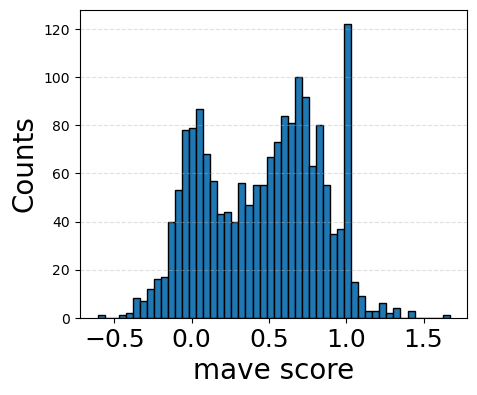

In [158]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
score_histogram(P63165_functional_mave,50,'C0','mave score',True,-7.5)
#plt.savefig('./Figures/P35520_CBS_MAVE_threshold_histogram.pdf')

In [159]:
y,x,_=plt.hist(P63165_functional_mave[~np.isnan(P63165_functional_mave)],100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(0.0,0.2,60,0.7,0.2,100,1.0,0.05,60)
params,cov=curve_fit(bimodal,x,y,p0=expected)
sigma=sp.sqrt(sp.diag(cov))
plt.close()

In [160]:
gaus_fit_params=pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
print(gaus_fit_params)

            params         sigma
mu1       0.030635  7.205831e-03
sigma1    0.138724  7.284104e-03
A1       39.353446  1.517557e+00
mu2       0.651066  7.965585e-03
sigma2    0.219651  9.304924e-03
A2       44.535523  1.251221e+00
mu3       0.989664  2.508318e+01
sigma3    0.005441  2.059856e+01
A3      307.599684  4.672256e+06


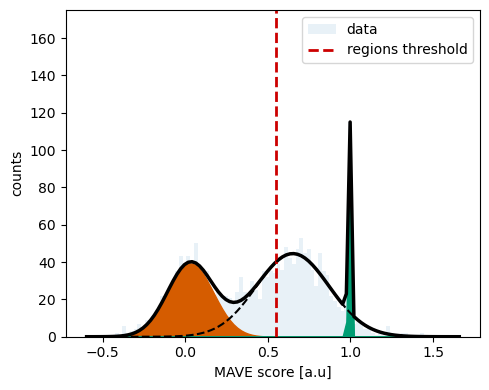

In [161]:
fig,ax=plt.subplots(1,1,figsize=(5,4),tight_layout=True)
ax.hist(P63165_functional_mave[~np.isnan(P63165_functional_mave)],100,alpha=.1,label='data')

ax.plot(x,gauss(x,gaus_fit_params.iloc[3,0],gaus_fit_params.iloc[4,0],gaus_fit_params.iloc[5,0]),color='black',zorder=3,ls='--')
ax.fill_between(x,gauss(x,gaus_fit_params.iloc[0,0],gaus_fit_params.iloc[1,0],gaus_fit_params.iloc[2,0]),color='#D55C00',zorder=2)
ax.fill_between(x,gauss(x,gaus_fit_params.iloc[6,0],gaus_fit_params.iloc[7,0],gaus_fit_params.iloc[8,0]),color='#009E74',zorder=2)
ax.plot(x,bimodal(x,*params),color='black',lw=2.5)

y_size=[0,175]
vert_line = np.array( [0.55 for i in range(len(y_size))])
ax.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=2)
ax.set_xlabel("MAVE score [a.u]")
ax.set_ylabel("counts")
ax.set_ylim(0,175)
ax.legend()
#plt.savefig('./Figures/P63165_SUMO1_MAVE_threshold_histogram.pdf')

### P51580 - TPMT

In [162]:
P51580_WT_sequence="MDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGHQLLKKHLDTFLKGKSGLRVFFPLCGKAVEMKWFADRGHSVVGVEISELGIQEFFTEQNLSYSEEPITEIPGTKVFKSSSGNISLYCCSIFDLPRTNIGKFDMIWDRGALVAINPGDRKCYADTMFSLLGKKFQYLLCVLSYDPTKHPGPPFYVPHAEIERLFGKICNIRCLEKVDAFEERHKSWGIDCLFEKLYLLTEK"
P51580_WT_seq_rose="----------------EVQKNQVLTLEEWQDKWVNGKTAFHQEQGHQLLKKHLDTFLKGKSGLRVFFPLCGKAVEMKWFADRGHSVVGVEISELGIQEFFTEQNLSYSEEPITEIPGTKVFKSSSGNISLYCCSIFDLPRTNIGKFDMIWDRGALVAINPGDRKCYADTMFSLLGKKFQYLLCVLSYDPTKHPGPPFYVPHAEIERLFGKICNIRCLEKVDAFEERHKSWGIDCLFEKLYLLTEK"
P51580_WT_seq_mave="MDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGHQLLKKHLDTFLKGKSGLRVFFPLCGKAVEMKWFADRGHSVVGVEISELGIQEFFTEQNLSYSEEPITEIPGTKVFKSSSGNISLYCCSIFDLPRTNIGKFDMIWDRGALVAINPGDRKCYADTMFSLLGKKFQYLLCVLSYDPTKHPGPPFYVPHAEIERLFGKICNIRCLEKVDAFEERHKSWGIDCLFEKLYLLTEK"

In [163]:
count=0
for i in range(len(P51580_WT_sequence)):
    if P51580_WT_sequence[i]==P51580_WT_seq_rose[i]:
        count+=1
print(len(P51580_WT_sequence),count/len(P51580_WT_seq_rose))

245 0.9346938775510204


#### Co-evolution

In [167]:
P51580_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P51580.txt',P51580_WT_sequence)
P51580_GEMME=remove_WT_score(P51580_GEMME,P51580_WT_sequence)

In [168]:
P51580_GEMME_mean=position_mean(P51580_GEMME)

####  Rosetta ddG

In [169]:
P51580_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P51580.txt",P51580_WT_seq_rose,0)
P51580_rosetta_ddg=remove_WT_score(P51580_rosetta_ddg,P51580_WT_seq_rose)

In [170]:
P51580_rosetta_ddg_norm=normalize_cutoff(P51580_rosetta_ddg,0.0,5.0)

In [171]:
P51580_rosetta_ddg_mean=position_mean(P51580_rosetta_ddg_norm)

In [172]:
P51580_rosetta_ddg_mean_non=position_mean(P51580_rosetta_ddg)

#### Hydrophobicity

In [173]:
P51580_hydrophobicity_mut=np.empty((len(P51580_WT_sequence),20),dtype=float)
P51580_hydrophobicity_mut[:]=np.nan

In [174]:
for i in range(len(P51580_WT_sequence)):
    for j in range(20):
        P51580_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [175]:
P51580_wcn=WCN('../pdbs/P51580_2h11.pdb','ca',P51580_WT_sequence)

#### Neighbor sequences scores:

In [176]:
P51580_rosetta_neigbor_scores=neighbor_scores(P51580_rosetta_ddg_mean,1)

P51580_GEMME_neigbor_scores=neighbor_scores(P51580_GEMME_mean,1)

#### MAVE score

In [178]:
P51580_functional_mave=load_data_V2('../score_maves/prism_mave_014_TPMT_abundance.txt',P51580_WT_seq_mave)

Wt-like variants: 3828  ( 1.0 )


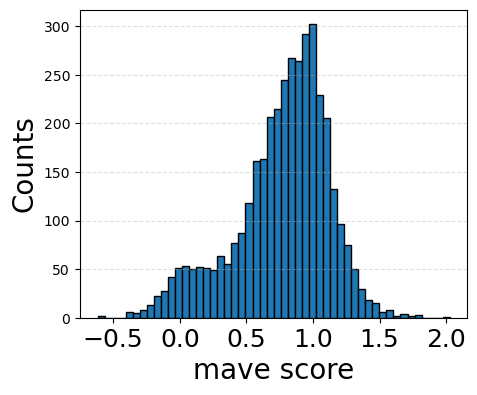

In [180]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
score_histogram(P51580_functional_mave,50,'C0','mave score',True,-7.5)
#plt.savefig('./Figures/P35520_CBS_MAVE_threshold_histogram.pdf')

In [181]:
y,x,_=plt.hist(P51580_functional_mave[~np.isnan(P51580_functional_mave)],100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(0.0,0.25,50,0.6,0.1,150,1.0,0.2,30)
params,cov=curve_fit(bimodal,x,y)#,p0=expected)
sigma=sp.sqrt(sp.diag(cov))
plt.close()

In [182]:
gaus_fit_params=pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
print(gaus_fit_params)

            params     sigma
mu1       0.555333  0.053534
sigma1   -0.483136  0.033796
A1       35.183501  3.996710
mu2       0.649285  0.026304
sigma2   -0.107230  0.020831
A2       39.502907  9.492621
mu3       0.954000  0.014512
sigma3   -0.163029  0.012951
A3      120.255542  5.292845


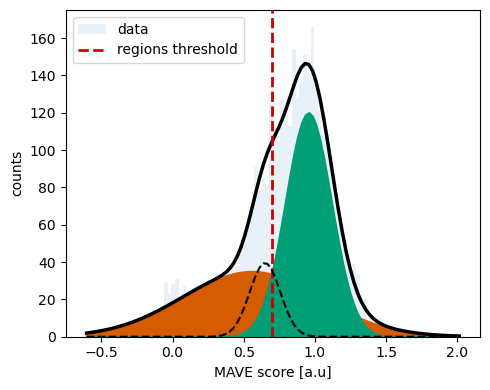

In [183]:
fig,ax=plt.subplots(1,1,figsize=(5,4),tight_layout=True)
ax.hist(P51580_functional_mave[~np.isnan(P51580_functional_mave)],100,alpha=.1,label='data')

ax.plot(x,gauss(x,gaus_fit_params.iloc[3,0],gaus_fit_params.iloc[4,0],gaus_fit_params.iloc[5,0]),color='black',zorder=3,ls='--')
ax.fill_between(x,gauss(x,gaus_fit_params.iloc[0,0],gaus_fit_params.iloc[1,0],gaus_fit_params.iloc[2,0]),color='#D55C00',zorder=2)
ax.fill_between(x,gauss(x,gaus_fit_params.iloc[6,0],gaus_fit_params.iloc[7,0],gaus_fit_params.iloc[8,0]),color='#009E74',zorder=2)
ax.plot(x,bimodal(x,*params),color='black',lw=2.5)

y_size=[0,175]
vert_line = np.array( [0.7 for i in range(len(y_size))])
ax.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=2)
ax.set_xlabel("MAVE score [a.u]")
ax.set_ylabel("counts")
ax.set_ylim(0,175)
ax.legend()
#plt.savefig('./Figures/P51580_TPMT_MAVE_threshold_histogram.pdf')

In [190]:
count_SBI_model7=[0,0,0]

In [191]:
count_SBI_perc_2x=[]

In [192]:
asa_SBI_data=[]

In [193]:
ss_SBI_data=[]

In [194]:
AA_SBI_data=[]

In [195]:
SBI_accuracy=[]
overall_accuracy=[]

In [196]:
count_neg_SBI_cat_levels=[]

## Predictions

#### P35520 Prediction

In [197]:
P35520_X,P35520_map=features_validation([P35520_GEMME, P35520_rosetta_ddg_norm,P35520_GEMME_mean,P35520_rosetta_ddg_mean,P35520_hydrophobicity_mut,P35520_GEMME_neigbor_scores,P35520_rosetta_neigbor_scores,P35520_wcn],P35520_WT_sequence)

In [198]:
prediction=cat.predict(P35520_X)

In [199]:
P35520_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P35520_map,P35520_WT_sequence,0.50)

In [200]:
pred_score,mave_filtered=distribution_experiments(prediction,P35520_map,P35520_WT_seq_mave,P35520_functional_mave)

In [202]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P35520_3mode_prediction,P35520_WT_sequence,P35520_WT_seq_rose))

 SBI variants: 2515 out of 8145 (30.88%) 
 SBI residues: 124 out of 493 (25.15%) 


In [203]:
print(mave_filtered.shape)
print(pred_score.shape)

(551, 20)
(551, 20)


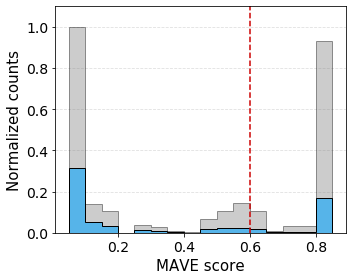

In [387]:
classification_histogram_shadowed(P35520_functional_mave,pred_score,20,0.1,.8,'#56b4e9',"MAVE score",1)
y_size=[0,1.2]
vert_line = np.array( [0.6 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P35520_SBI_MAVE_variant_distribution.pdf')

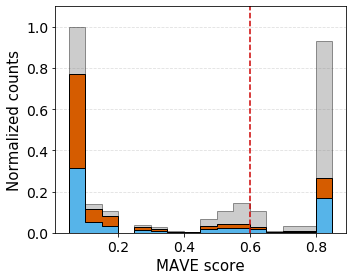

In [388]:
classification_histogram_shadowed2(P35520_functional_mave,pred_score,20,0.1,.8,['#56b4e9','#d55c00'],"MAVE score",[1,2])
y_size=[0,1.2]
vert_line = np.array( [0.6 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P35520_SBI_blue_red_MAVE_variant_distribution.pdf')

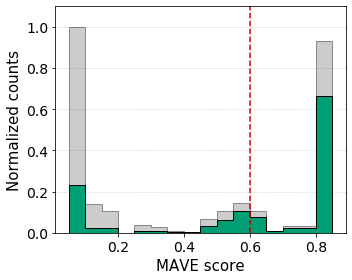

In [389]:
classification_histogram_shadowed2(P35520_functional_mave,pred_score,20,0.1,.8,['#009e74','#f0e442'],"MAVE score",[0,3])
y_size=[0,1.2]
vert_line = np.array( [0.6 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P35520_SBI_green_yellow_MAVE_variant_distribution.pdf')

In [390]:
P35520_SBI_mave_score=[]
for i in range(len(P35520_3mode_prediction)):
    if P35520_3mode_prediction[i]==1:
        P35520_SBI_mave_score.append(np.nanmean(P35520_functional_mave[i,:]))
P35520_SBI_mave_score=np.array(P35520_SBI_mave_score)

In [391]:
for i in 2,1:
    overall_accuracy.append(print_accuracy_exp_predictions(P35520_functional_mave,pred_score,0.6,'under',i))
for i in 3,0:
    overall_accuracy.append(print_accuracy_exp_predictions(P35520_functional_mave,pred_score,0.6,'over',i))

2 2220 347 0.8648227502921698
1 1754 571 0.7544086021505376
3 0 0 nan
0 2387 2069 0.5356822262118492


#### P62593 Prediction

In [392]:
BETA_X,BETA_map=features_validation([BETA_GEMME, BETA_rosetta_ddg_norm,BETA_GEMME_mean,BETA_rosetta_ddg_mean,BETA_hydrophobicity_mut,BETA_GEMME_neigbor_scores,BETA_rosetta_neigbor_scores,BETA_wcn],BETA_WT_sequence)

In [393]:
prediction=cat.predict(BETA_X)

In [394]:
BETA_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,BETA_map,BETA_WT_sequence,0.50)

In [396]:
pred_score,mave_filtered=distribution_experiments(prediction,BETA_map,BETA_WT_seq_mave,BETA_functional_mave)

In [397]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,BETA_3mode_prediction,BETA_WT_sequence,BETA_WT_seq_rose))

 SBI variants: 632 out of 4995 (12.65%) 
 SBI residues: 23 out of 261 (8.81%) 


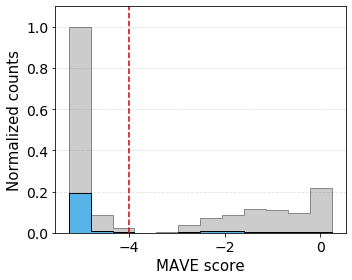

In [398]:
classification_histogram_shadowed(BETA_functional_mave,pred_score,20,-5,-0.1,'#56b4e9',"MAVE score",1)
y_size=[0,1.2]
vert_line = np.array( [-4 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P62593_SBI_MAVE_variant_distribution.pdf')

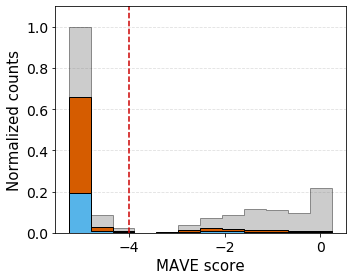

In [399]:
classification_histogram_shadowed2(BETA_functional_mave,pred_score,20,-5,-0.1,['#56b4e9','#d55c00'],"MAVE score",[1,2])
y_size=[0,1.2]
vert_line = np.array( [-4 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P62593_SBI_blue_red_MAVE_variant_distribution.pdf')

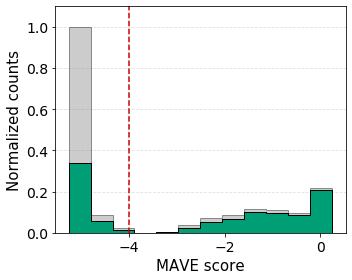

In [400]:
classification_histogram_shadowed2(BETA_functional_mave,pred_score,20,-5,-0.1,['#009e74','#f0e422'],"MAVE score",[0,3])
y_size=[0,1.2]
vert_line = np.array( [-4 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P62593_SBI_green_yellow_MAVE_variant_distribution.pdf')

In [401]:
BETA_SBI_mave_score=[]
for i in range(len(BETA_3mode_prediction)):
    if BETA_3mode_prediction[i]==1:
        BETA_SBI_mave_score.append(np.nanmean(BETA_functional_mave[i,:]))
BETA_SBI_mave_score=np.array(BETA_SBI_mave_score)

In [402]:
for i in 2,1:
    overall_accuracy.append(print_accuracy_exp_predictions(BETA_functional_mave,pred_score,-4,'under',i))
for i in 3,0:
    overall_accuracy.append(print_accuracy_exp_predictions(BETA_functional_mave,pred_score,-4,'over',i))

2 1134 232 0.8301610541727672
1 481 151 0.7610759493670886
3 0 0 nan
0 1985 1012 0.662328995662329


#### P04386 Prediction

In [403]:
P04386_X,P04386_map=features_validation([P04386_GEMME, P04386_rosetta_ddg_norm,P04386_GEMME_mean,P04386_rosetta_ddg_mean,P04386_hydrophobicity_mut,P04386_GEMME_neigbor_scores,P04386_rosetta_neigbor_scores,P04386_wcn],P04386_WT_sequence)

In [404]:
prediction=cat.predict(P04386_X)

In [405]:
P04386_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P04386_map,P04386_WT_sequence,0.50)

In [407]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P04386_3mode_prediction,P04386_WT_sequence,P04386_WT_seq_rose))

 SBI variants: 363 out of 1691 (21.47%) 
 SBI residues: 18 out of 89 (20.22%) 


In [408]:
pred_score,mave_filtered=distribution_experiments(prediction,P04386_map,P04386_WT_seq_mave,P04386_functional_mave)

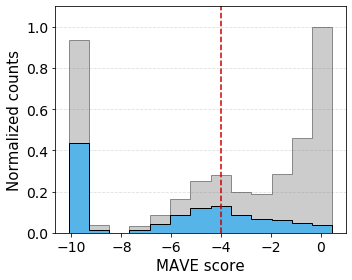

In [409]:
classification_histogram_shadowed(P04386_functional_mave,pred_score,20,-9.5,-0.1,'#56b4e9',"MAVE score",1)
y_size=[0,1.2]
vert_line = np.array( [-4 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P04386_SBI_MAVE_variant_distribution.pdf')

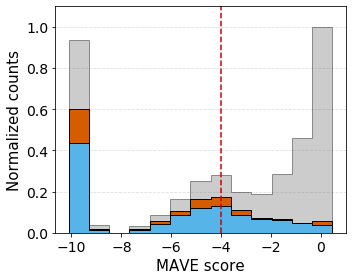

In [410]:
classification_histogram_shadowed2(P04386_functional_mave,pred_score,20,-9.5,-0.1,['#56b4e9','#d55c00'],"MAVE score",[1,2])
y_size=[0,1.2]
vert_line = np.array( [-4 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P04386_SBI_blue_red_MAVE_variant_distribution.pdf')

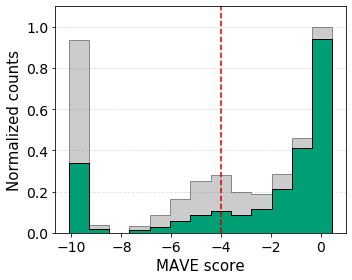

In [411]:
classification_histogram_shadowed2(P04386_functional_mave,pred_score,20,-9.5,-0.1,['#009e74','#f0e442'],"MAVE score",[0,3])
y_size=[0,1.2]
vert_line = np.array( [-4 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P04386_SBI_green_yellow_MAVE_variant_distribution.pdf')

In [412]:
P04386_SBI_mave_score=[]
for i in range(len(P04386_3mode_prediction)):
    if P04386_3mode_prediction[i]==1:
        P04386_SBI_mave_score.append(np.nanmean(P04386_functional_mave[i,:]))
P04386_SBI_mave_score=np.array(P04386_SBI_mave_score)

In [413]:
for i in 2,1:
    overall_accuracy.append(print_accuracy_exp_predictions(P04386_functional_mave,pred_score,-4,'under',i))
for i in 3,0:
    overall_accuracy.append(print_accuracy_exp_predictions(P04386_functional_mave,pred_score,-4,'over',i))

2 78 22 0.78
1 225 103 0.6859756097560976
3 0 0 nan
0 481 175 0.7332317073170732


#### P63165 Prediction

In [424]:
P63165_X,P63165_map=features_validation([P63165_GEMME, P63165_rosetta_ddg_norm,P63165_GEMME_mean,P63165_rosetta_ddg_mean,P63165_hydrophobicity_mut,P63165_GEMME_neigbor_scores,P63165_rosetta_neigbor_scores,P63165_wcn],P63165_WT_sequence)

In [425]:
prediction=cat.predict(P63165_X)

In [426]:
P63165_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P63165_map,P63165_WT_sequence,0.50)

In [428]:
pred_score,mave_filtered=distribution_experiments(prediction,P63165_map,P63165_WT_seq_mave,P63165_functional_mave)

In [429]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P63165_3mode_prediction,P63165_WT_sequence,P63165_WT_seq_rose))

 SBI variants: 355 out of 1501 (23.65%) 
 SBI residues: 17 out of 79 (21.52%) 


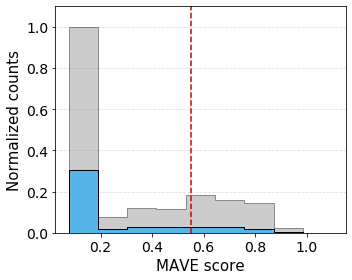

In [430]:
classification_histogram_shadowed(P63165_functional_mave,pred_score,20,0.1,1,'#56b4e9',"MAVE score",1)
y_size=[0,1.2]
vert_line = np.array( [0.55 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P63165_SBI_MAVE_variant_distribution.pdf')

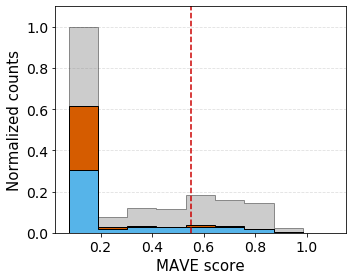

In [431]:
classification_histogram_shadowed2(P63165_functional_mave,pred_score,20,0.1,1,['#56b4e9','#d55c00'],"MAVE score",[1,2])
y_size=[0,1.2]
vert_line = np.array( [0.55 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P63165_blue_red_SBI_MAVE_variant_distribution.pdf')

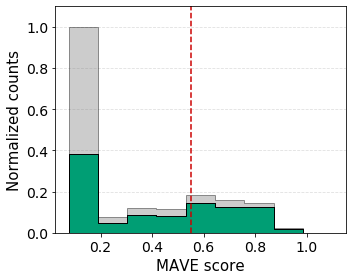

In [432]:
classification_histogram_shadowed2(P63165_functional_mave,pred_score,20,0.1,1,['#009e74','#f0e442'],"MAVE score",[0,3])
y_size=[0,1.2]
vert_line = np.array( [0.55 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P63165_SBI_green_yellow_MAVE_variant_distribution.pdf')

In [433]:
P63165_functional_mave.shape

(101, 20)

In [434]:
P63165_SBI_mave_score=[]
for i in range(len(P63165_3mode_prediction)):
    if P63165_3mode_prediction[i]==1:
        P63165_SBI_mave_score.append(np.nanmean(P63165_functional_mave[i,:]))
P63165_SBI_mave_score=np.array(P63165_SBI_mave_score)

In [435]:
for i in 2,1:
    overall_accuracy.append(print_accuracy_exp_predictions(P63165_functional_mave,pred_score,0.55,'under',i))
for i in 3,0:
    overall_accuracy.append(print_accuracy_exp_predictions(P63165_functional_mave,pred_score,0.55,'over',i))

2 194 13 0.9371980676328503
1 236 80 0.7468354430379747
3 0 0 nan
0 416 445 0.4831591173054588


#### P51580 Prediction

In [436]:
P51580_X,P51580_map=features_validation([P51580_GEMME, P51580_rosetta_ddg_norm,P51580_GEMME_mean,P51580_rosetta_ddg_mean,P51580_hydrophobicity_mut,P51580_GEMME_neigbor_scores,P51580_rosetta_neigbor_scores,P51580_wcn],P51580_WT_sequence)

In [437]:
prediction=cat.predict(P51580_X)

In [438]:
P51580_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P51580_map,P51580_WT_sequence,0.50)

In [440]:
pred_score,mave_filtered=distribution_experiments(prediction,P51580_map,P51580_WT_seq_mave,P51580_functional_mave)

In [441]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P51580_3mode_prediction,P51580_WT_sequence,P51580_WT_seq_rose))

 SBI variants: 505 out of 4351 (11.61%) 
 SBI residues: 15 out of 229 (6.55%) 


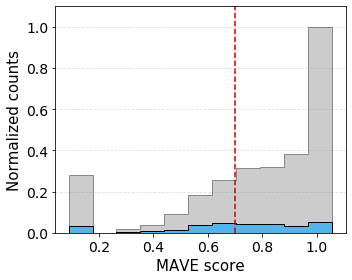

In [442]:
classification_histogram_shadowed(P51580_functional_mave,pred_score,30,0.1,1,'#56b4e9',"MAVE score",1)
y_size=[0,1.2]
vert_line = np.array( [0.7 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P51580_SBI_MAVE_variant_distribution.pdf')

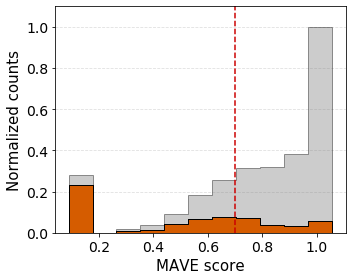

In [443]:
classification_histogram_shadowed2(P51580_functional_mave,pred_score,30,0.1,1,['#d55c00','#f0e442'],"MAVE score",[2,3])
y_size=[0,1.2]
vert_line = np.array( [0.7 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P51580_blue_red_SBI_MAVE_variant_distribution.pdf')

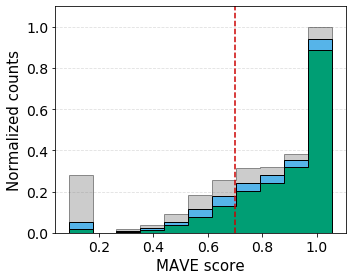

In [444]:
classification_histogram_shadowed2(P51580_functional_mave,pred_score,30,0.1,1,['#009e74','#56b4e9'],"MAVE score",[0,1])
y_size=[0,1.2]
vert_line = np.array( [0.7 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/P51580_SBI_green_yellow_MAVE_variant_distribution.pdf')

In [445]:
P51580_functional_mave.shape

(245, 20)

In [446]:
P51580_SBI_mave_score=[]
for i in range(len(P51580_3mode_prediction)):
    if P51580_3mode_prediction[i]==1:
        P51580_SBI_mave_score.append(np.nanmean(P51580_functional_mave[i,:]))
P51580_SBI_mave_score=np.array(P51580_SBI_mave_score)

In [447]:
SBI_accuracy.append(print_accuracy_exp_predictions(P51580_functional_mave,pred_score,0.7,'under',1))

1 213 184 0.5365239294710328


In [448]:
for i in 3,2:
    overall_accuracy.append(print_accuracy_exp_predictions(P51580_functional_mave,pred_score,0.7,'under',i))
for i in 1,0:
    overall_accuracy.append(print_accuracy_exp_predictions(P51580_functional_mave,pred_score,0.7,'over',i))

3 0 0 nan
2 673 219 0.7544843049327354
1 184 213 0.4634760705289673
0 1716 422 0.8026192703461179


### Results

In [460]:
overall_accuracy=np.array(overall_accuracy)

In [461]:
np.nanmean(overall_accuracy[:,3])

0.7196972779142679

In [462]:
for i in range(0,4):
    temp=[]
    for j in range(overall_accuracy.shape[0]):
        if overall_accuracy[j,0]==i:
            temp.append(overall_accuracy[j,3])
    temp=np.array(temp)
    print(np.mean(temp))

0.6434042633685657
0.6823543349681331
0.8333332354061046
nan
